In [1]:
!pip install fastbook -q
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.19
torch version: 2.6.0+cu124


In [4]:
from google.colab import drive #掛載雲端硬碟
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = Path('/content/drive/MyDrive/SDG/weatherdataset')

In [6]:
from fastai.vision.all import * #參考GPT

path = Path('/content/drive/MyDrive/SDG/split_weatherdataset')

# 這行會去 path/train 和 path/val 自動讀資料
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='val',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
    bs=16,  # 可調整
    num_workers=4  # Colab 記得設小一點，16 太大會炸掉
)


#讀取結果
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds))

5 ['drought', 'raining ', 'sandstorm', 'tornado', 'tsunami'] 601 119


In [7]:
test_path = Path('/content/drive/MyDrive/SDG/split_weatherdataset/test')
test_dl = dls.test_dl(get_image_files(test_path), with_labels=True)

In [8]:
myPath='/content/drive/MyDrive/SDG/models'

##載回PK2權重

In [9]:
learn_resnet = load_learner(f'{myPath}/resnet34_stage-2.pkl')
learn_vgg = load_learner(f'{myPath}/vggstage-2.pkl')
learn_effnet = load_learner(f'{myPath}/effnetstage-2.pkl')


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [10]:
learn_resnet.dls = dls
learn_vgg.dls = dls
learn_effnet.dls = dls  #.pkl 載入模型的時候，dls 不一定會自動附上來

##ROC resnet

## ROC resnet test

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc


ResNet test Accuracy: 75.19%


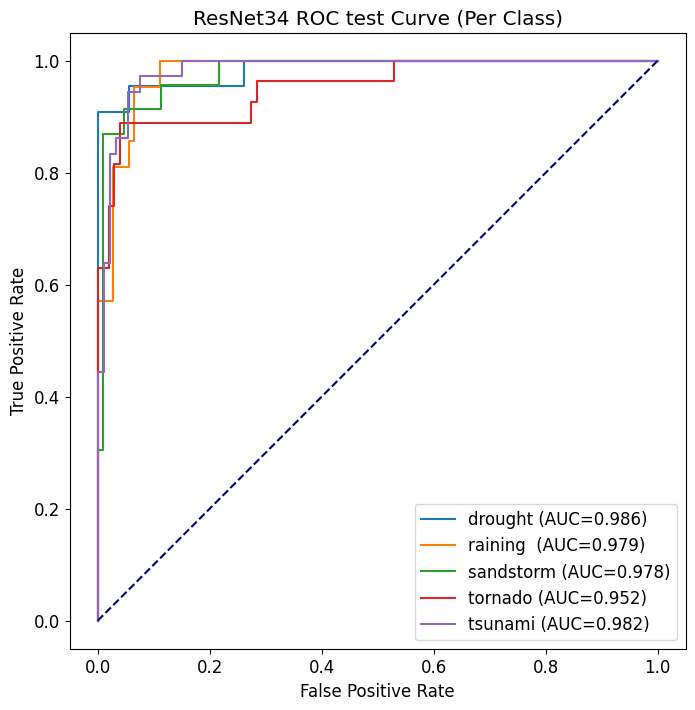

In [ ]:
preds_r, y_r, loss_r = learn_resnet.get_preds(dl=test_dl, with_loss=True)

#get accuracy
acc_r = accuracy(preds_r, y_r)
print('ResNet test Accuracy: {:.2f}%'.format(100 * float(acc_r)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_r[:, i])
  fpr, tpr, thresholds = roc_curve(y_r.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('ResNet34 ROC test Curve (Per Class)')
plt.legend(loc="lower right")

## *val*/train

ResNet Accuracy: 76.47%


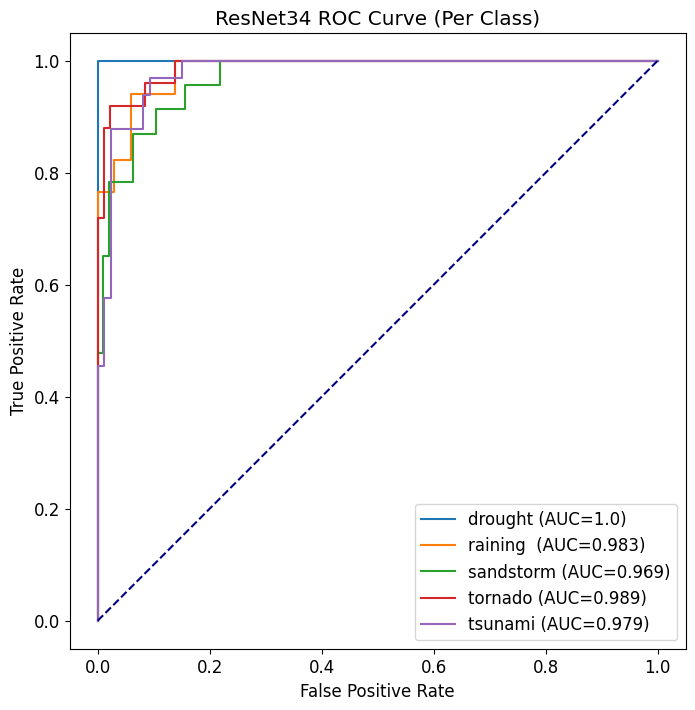

In [ ]:
preds_r, y_r, loss_r = learn_resnet.get_preds(with_loss=True)

#get accuracy
acc_r = accuracy(preds_r, y_r)
print('ResNet Accuracy: {:.2f}%'.format(100 * float(acc_r)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_r[:, i])
  fpr, tpr, thresholds = roc_curve(y_r.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('ResNet34 ROC Curve (Per Class)')
plt.legend(loc="lower right")

## ROC VGG test

VGG16 Accuracy: 64.34%


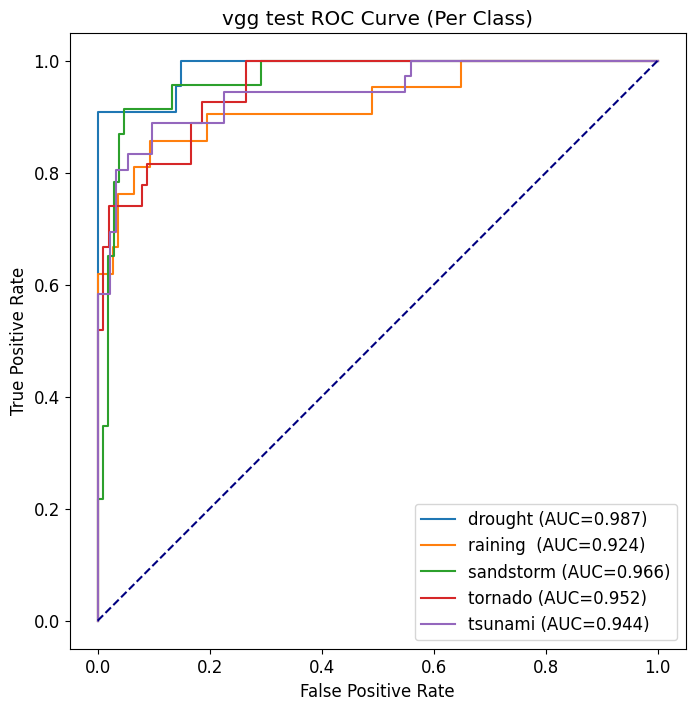

In [ ]:
preds_v, y_v, loss_v = learn_vgg.get_preds(dl=test_dl, with_loss=True)
acc_v = accuracy(preds_v, y_v)
print('VGG16 Accuracy: {:.2f}%'.format(100 * float(acc_v)))
class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_v[:, i])
  fpr, tpr, thresholds = roc_curve(y_v.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('vgg test ROC Curve (Per Class)')
plt.legend(loc="lower right")


##val/train

VGG16 Accuracy: 66.39%


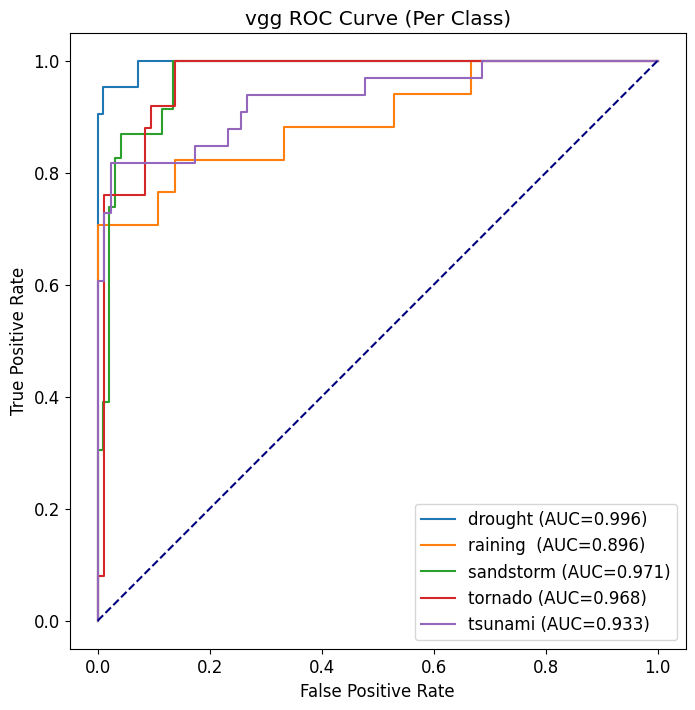

In [ ]:
preds_v, y_v, loss_v = learn_vgg.get_preds(with_loss=True)
acc_v = accuracy(preds_v, y_v)
print('VGG16 Accuracy: {:.2f}%'.format(100 * float(acc_v)))
class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_v[:, i])
  fpr, tpr, thresholds = roc_curve(y_v.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('vgg ROC Curve (Per Class)')
plt.legend(loc="lower right")

## EFF Roc test



EffNet test Accuracy: 75.19%


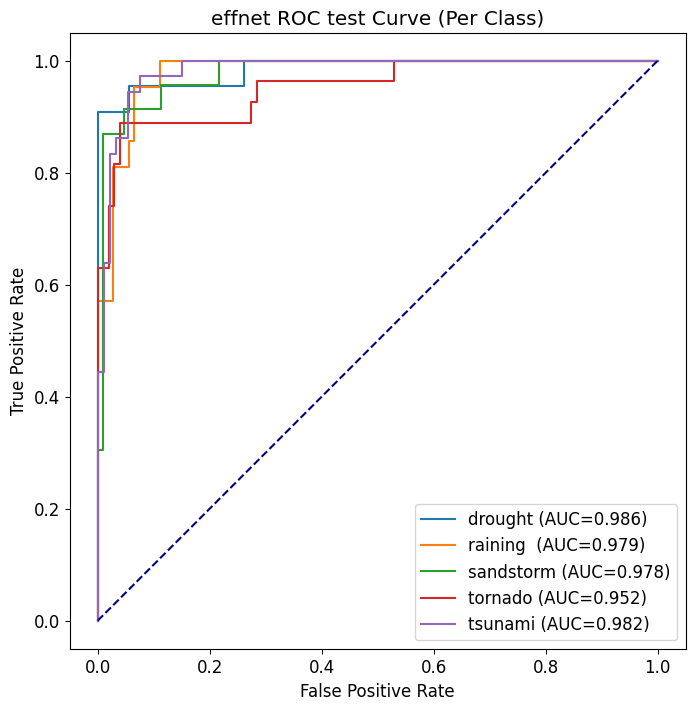

In [ ]:
preds_e, y_e, loss_e = learn_effnet.get_preds(dl=test_dl, with_loss=True)

#get accuracy
acc_r = accuracy(preds_r, y_r)
print('EffNet test Accuracy: {:.2f}%'.format(100 * float(acc_r)))

class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_r[:, i])
  fpr, tpr, thresholds = roc_curve(y_e.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('effnet ROC test Curve (Per Class)')
plt.legend(loc="lower right")

##ROC val/train

EffNet Accuracy: 52.94%


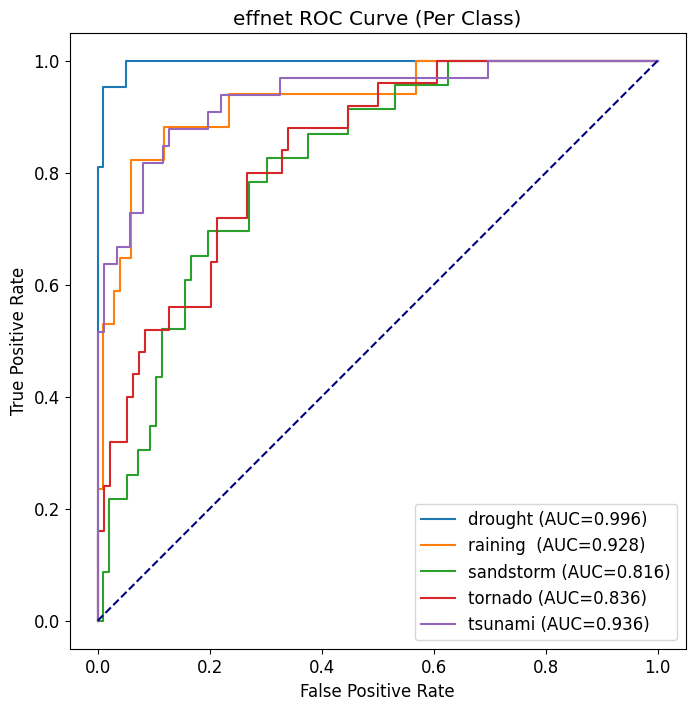

In [ ]:
preds_e, y_e, loss_e = learn_effnet.get_preds(with_loss=True) #GPT
acc_e = accuracy(preds_e, y_e)
print('EffNet Accuracy: {:.2f}%'.format(100 * float(acc_e)))
class_num = dls.c
class_name = dls.vocab

plt.figure(figsize=(8,8))
for i in range(class_num):
  probs = np.array(preds_e[:, i])
  fpr, tpr, thresholds = roc_curve(y_e.numpy(), probs, pos_label=i)  # ⭐加上 .numpy()GPT
  #compute ROC area
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='{0} (AUC={1})'.format(class_name[i], round(roc_auc,3)))
plt.plot([0,1],[0,1],color='navy', linestyle='--')
plt.xlim([-0.01,1.01]) # Changed xLim to xlim
plt.ylim([-0.01,1.01]) # Changed yLim to ylim
plt.axis('square')
plt.xlabel('False Positive Rate') # Changed xlim to xlabel
plt.ylabel('True Positive Rate') # Changed ylim to ylabel
plt.title('effnet ROC Curve (Per Class)')
plt.legend(loc="lower right")

In [13]:
preds_r, y_r, loss_r = learn_resnet.get_preds(dl=test_dl, with_loss=True)
preds_v, y_v, loss_v = learn_vgg.get_preds(dl=test_dl, with_loss=True)
preds_e, y_e, loss_e = learn_effnet.get_preds(dl=test_dl, with_loss=True)


In [16]:
import pandas as pd #參考GpT格式化
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 將 FastAI 的結果轉為 numpy 陣列
y_r_np = y_r.numpy()
y_v_np = y_v.numpy()
y_e_np = y_e.numpy()
p_r_np = preds_r.numpy()
p_v_np = preds_v.numpy()
p_e_np = preds_e.numpy()

# 取最大機率作為預測類別
y_pred_r = p_r_np.argmax(axis=1)
y_pred_v = p_v_np.argmax(axis=1)
y_pred_e = p_e_np.argmax(axis=1)

# 模型與資料對應（已換成真實名稱）
model_data = [
    ("ResNet34", y_r_np, y_pred_r, p_r_np),
    ("VGG16", y_v_np, y_pred_v, p_v_np),
    ("EfficientNetB0", y_e_np, y_pred_e, p_e_np)
]

# 建立表格
rows = []
for name, y_true, y_pred, probs in model_data:
    row = {
        "Model": name,
        "Accuracy": round(accuracy_score(y_true, y_pred), 2),
        "Precision Micro": round(precision_score(y_true, y_pred, average="micro"), 2),
        "Precision Macro": round(precision_score(y_true, y_pred, average="macro"), 2),
        "Recall Micro": round(recall_score(y_true, y_pred, average="micro"), 2),
        "Recall Macro": round(recall_score(y_true, y_pred, average="macro"), 2),
        "F1 Micro": round(f1_score(y_true, y_pred, average="micro"), 2),
        "F1 Macro": round(f1_score(y_true, y_pred, average="macro"), 2),
        "AUC Weighted": round(roc_auc_score(y_true, probs, average="weighted", multi_class="ovr"), 2),
        "AUC Macro": round(roc_auc_score(y_true, probs, average="macro", multi_class="ovr"), 2),
    }
    rows.append(row)

# 建立 DataFrame
df = pd.DataFrame(rows)

# 輸出整齊表格
print(df.to_string(index=False))


         Model  Accuracy  Precision Micro  Precision Macro  Recall Micro  Recall Macro  F1 Micro  F1 Macro  AUC Weighted  AUC Macro
      ResNet34      0.75             0.75             0.82          0.75          0.76      0.75      0.75          0.98       0.98
         VGG16      0.64             0.64             0.83          0.64          0.68      0.64      0.67          0.95       0.95
EfficientNetB0      0.58             0.58             0.74          0.58          0.63      0.58      0.57          0.89       0.89


##Resnet現最好，畫Grad-CAM

##讀取檔案送入模型預測

In [ ]:
## 執行預測 - method I
fnames_class0 = get_image_files('/content/drive/MyDrive/SDG/split_weatherdataset/test/drought')
fnames_class1 = get_image_files('/content/drive/MyDrive/SDG/split_weatherdataset/test/raining ')
fnames_class2 = get_image_files('/content/drive/MyDrive/SDG/split_weatherdataset/test/sandstorm')
fnames_class3 = get_image_files('/content/drive/MyDrive/SDG/split_weatherdataset/test/tornado')
fnames_class4 = get_image_files('/content/drive/MyDrive/SDG/split_weatherdataset/test/tsunami')


In [ ]:
test_dl =learn_vgg.dls.test_dl(fnames_class1, with_label=True)
print(len(test_dl.get_idxs()))
# pred_probas, _,pred_classes = learn.get_preds(dl=test_dl, with_decoded=True)

21


In [ ]:
from torchvision.transforms.functional import to_tensor

fn = test_dl.items[1]
# 使用 PILImage.create() 创建图像对象，并指定模式为 'RGB'
x_dec = PILImage.create(fn);  # Ensure it's in R
print(x_dec.shape,fn)
#Resize: 224 填充黑邊
rsz=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
x_dec=rsz(x_dec)
print(x_dec.shape)
x = to_tensor(x_dec)
# 将 unsqueeze 的结果赋值回 x
x = x.unsqueeze(0)  # 在第0维添加一个维度，表示batch size
print(x.shape,type(x))

(573, 860) /content/drive/MyDrive/SDG/split_weatherdataset/test/raining /29d0eb73-c226-4bdc-9f45-64dea4690244.jpg
(224, 224)
torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>


In [ ]:
class Hook():
  def __init__(self, m):
     self.hook = m.register_forward_hook(self.hook_func)
  def hook_func(self, m, i, o): self.stored = o.detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [ ]:
class HookBwd():
  def __init__(self,m):
    self.hook = m.register_backward_hook(self.hook_func)
  def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.hook.remove()

In [ ]:
learn_resnet.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
cls=1
learn_resnet.model[0][7][2].conv2
with HookBwd(learn_vgg.model[0]) as hookg:
  with Hook(learn_vgg.model[0]) as hook:
    #output = learn.model.eval()(x.cuda())
    output = learn_vgg.model.eval()(x.cpu())
    act=hook.stored
  output[0,cls].backward()
  grad = hookg.stored

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


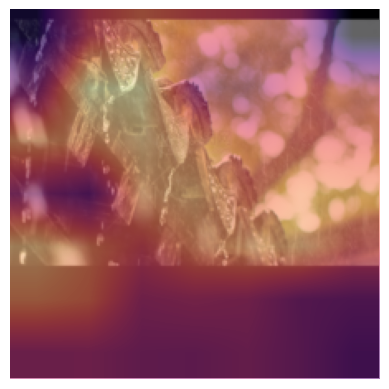

In [ ]:
w=grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w*act[0]).sum(0)

w=grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w*act[0]).sum(0)

_,ax=plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(),alpha=0.6, extent=(0,224,224,0),interpolation='bilinear', cmap='magma');
